In [1]:
from IPython.display import HTML, display


display(HTML("<style>.container { width:" + f"{90}% " + "!important; }</style>"))


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

# Computing FFT
* Goal: find out if cell phone data can recreate typical phenomena
* In order to compute FFT, we need a time series with evenly spaced points
* For every location, construct a time series of hourly pressure mean value

## Pre processing

**1. Clean outliers**

   - Based on z score. 
   - Every data point more than **5** standard deviations away from the mean pressure was removed.
    
*Example:* for location: latitude: 50, longitude: -5
    
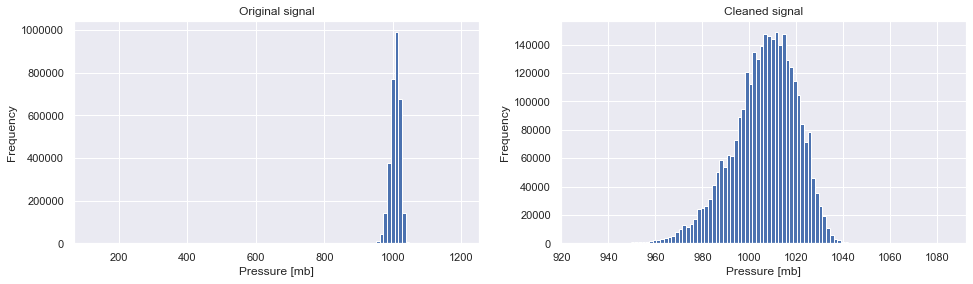

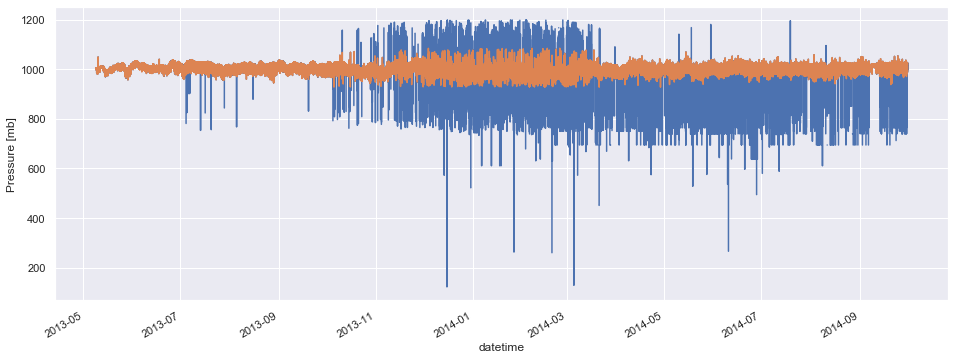

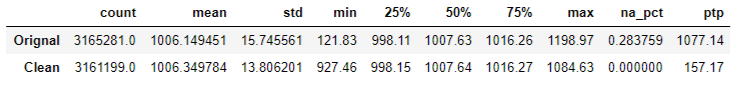

**2. Group by hours**

   - For every hour compute its mean pressure
    
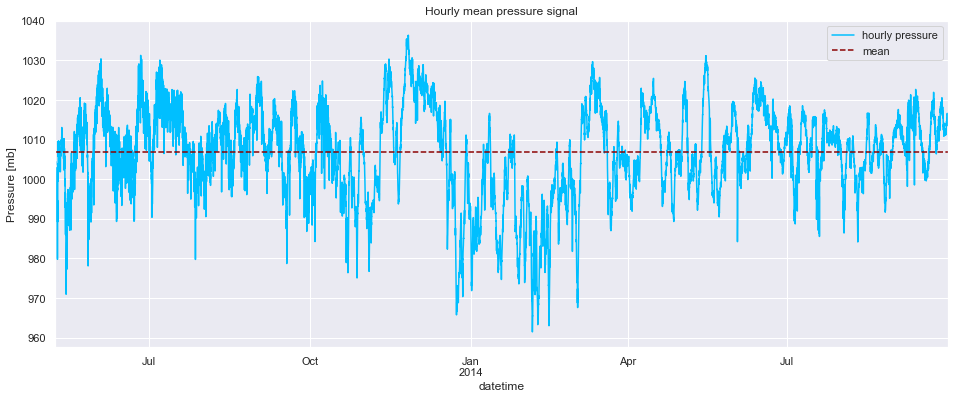

**3. Fill missing values**
* Hours with no data were filled with mean value of the hourly signal constructed by groupby

**4. Standardize signal**
* Use z score to standardize signal
* This is done to make data comparable with white noise, normally distributed around 0 with standard deviation of 1

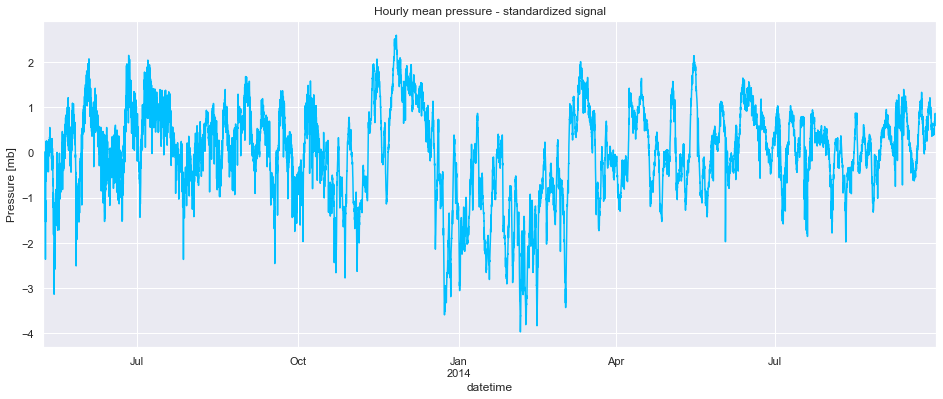

# Assessing statistical significance of spectral peaks

**Null hypothesis: time series is random, white noise**

The PSD (power spectral density) of white noise (normally distributed, mean 0, std of 1) **after normalization** is approximately distributed like chi square distribution with 2 degrees of freedom.

The idea is to use the chi square test to assess significance of spectral peaks

Notations:
* s - time series, real numbers
* S - FFT of s, complex numbers
* Sr - real part of S
* Si - imaginary part of S


$$
PSD = Sr^2 + Si^2
$$


$$
Normalized PSD = (\frac{Sr}{std(Sr)})^2 + (\frac{Si}{std(Si)})^2
$$

In [4]:
def compute_fft(signal):
    
    """
    Compute real fft for signal with a sampling rate 24 samples per day.
    Returns a dataframe with complex numbers, amplitude and PSD
    """
    
    # compute real fft on centered hourly mean time series
    n = len(signal)
    spectra = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(n=n, d=(1/24))
    
    # compute normalized psd
    real = spectra.real
    imag = spectra.imag
    psd_norm = (real / real.std())**2 + (imag / imag.std())**2

    # compute amplitude and psd from the complex numbers and store in df and return it
    fft_data = {"complex": spectra, "real": real, "imag": imag, 
                "amp": np.abs(spectra), "psd": np.abs(spectra)**2, "psd_norm": psd_norm}
    
    return pd.DataFrame(data=fft_data, index=pd.Index(freq, name="freq"))

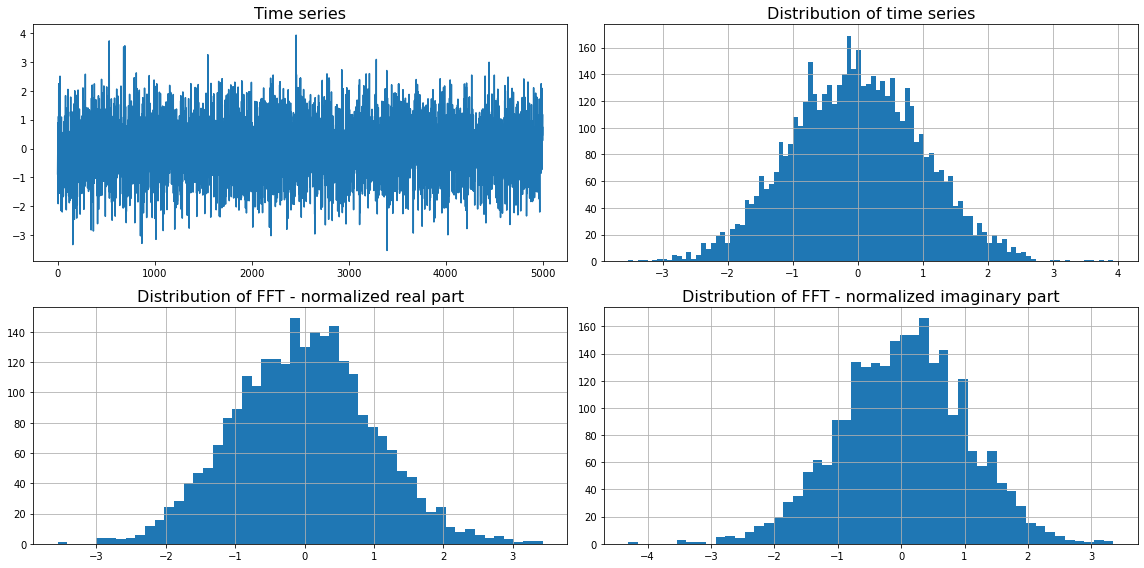

In [5]:
# generate random white noise and compute fft
white = pd.Series(np.random.normal(size=5000))
white_fft = compute_fft(white)

# initialize plt
fig, axes = plt.subplots(2,2, figsize=(16,8))
ax = axes.ravel()

# plot
white.plot(ax=ax[0])
white.hist(bins=100, ax=ax[1])
(white_fft["real"] / white_fft["real"].std()).hist(bins=50, ax=ax[2])
(white_fft["imag"] / white_fft["imag"].std()).hist(bins=50, ax=ax[3])

# set titles
fs = 16
ax[0].set_title("Time series", fontsize=fs)
ax[1].set_title("Distribution of time series", fontsize=fs)
ax[2].set_title("Distribution of FFT - normalized real part", fontsize=fs)
ax[3].set_title("Distribution of FFT - normalized imaginary part", fontsize=fs)

plt.tight_layout()
plt.show()

* In the case where the time series is normally distributed around mean $\mu$, so will be the real part and imaginary parts. FFT is a linear operation

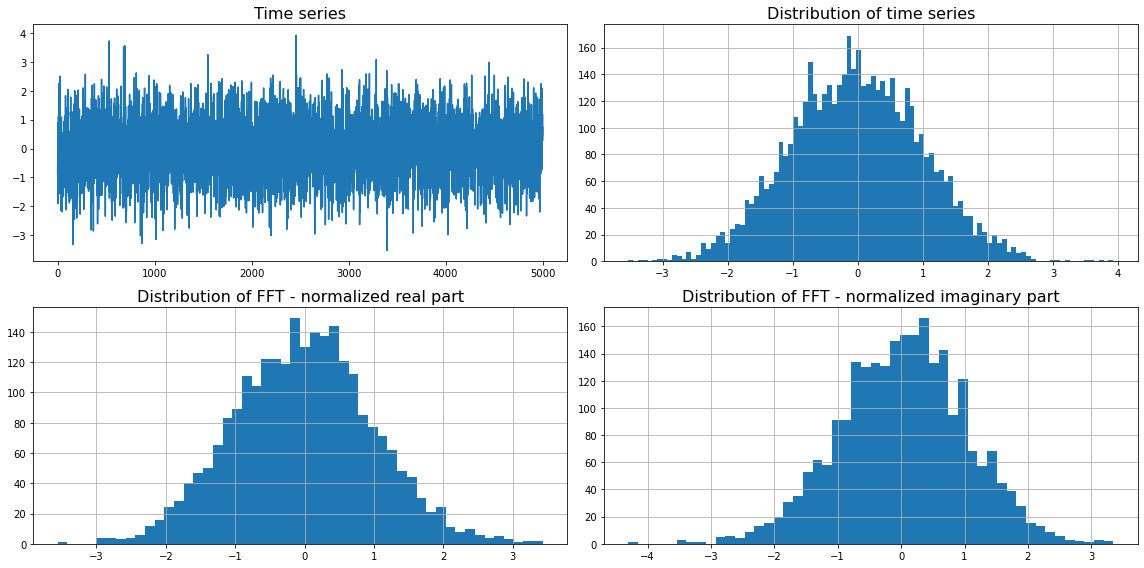

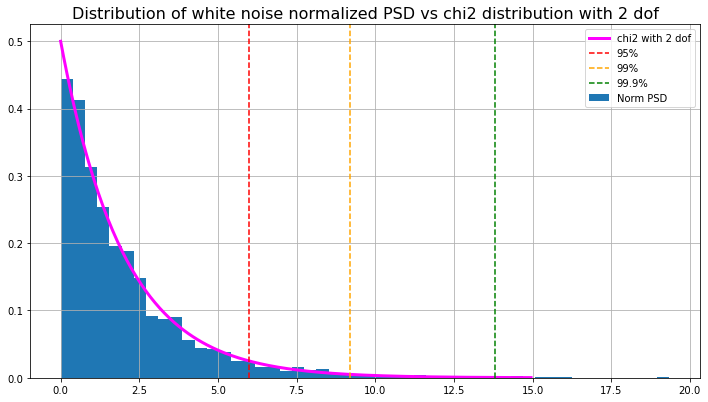

In [6]:
rv = stats.chi2(df=2)
chi95 = rv.ppf(0.95)
chi99 = rv.ppf(0.99)
chi999 = rv.ppf(0.999)

# plot dist of white normalized psd 
white_fft["psd_norm"].hist(bins=50, density=True, figsize=(12,6.5), label="Norm PSD")

# plot chi square dist with 2 dof
x = np.arange(0, 15, 0.05)
plt.plot(x, rv.pdf(x), color="magenta", lw=3, label="chi2 with 2 dof")

# plot confidence intervals
plt.axvline(chi95, color="r", linestyle="dashed", label="95%")
plt.axvline(chi99, color="orange", linestyle="dashed", label="99%")
plt.axvline(chi999, color="green", linestyle="dashed", label="99.9%")


plt.title("Distribution of white noise normalized PSD vs chi2 distribution with 2 dof", fontsize=16)
plt.legend(loc="upper right")


plt.show()

$$
Normalized PSD = (\frac{Sr}{std(Sr)})^2 + (\frac{Si}{std(Si)})^2
$$

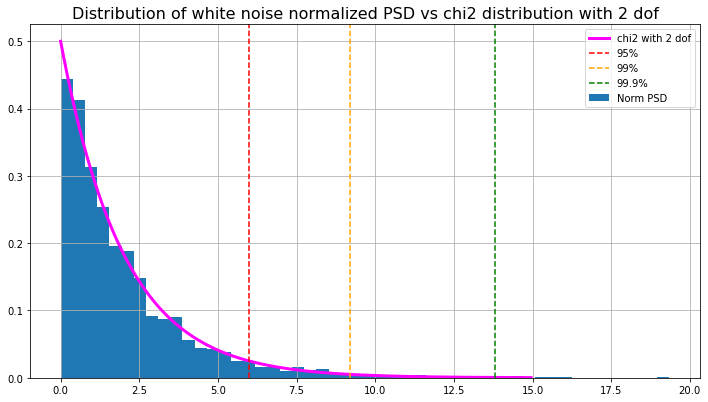

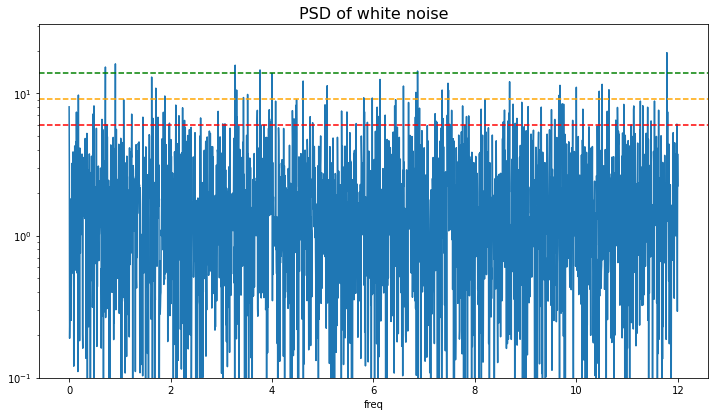

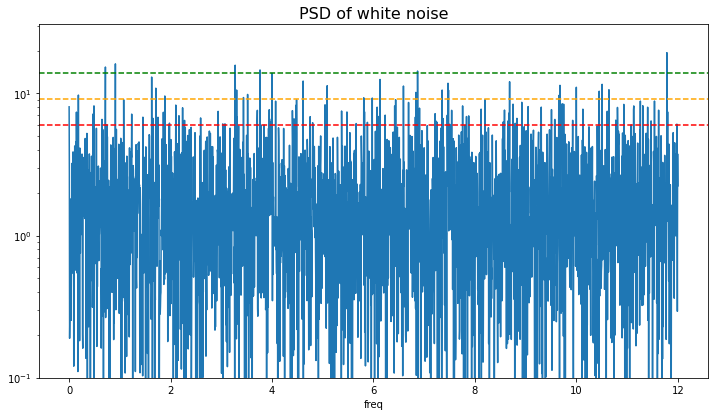

In [7]:
white_fft["psd_norm"].plot(logy=True, figsize=(12,6.5))

plt.axhline(chi95, color="r", linestyle="dashed", label="95%")
plt.axhline(chi99, color="orange", linestyle="dashed", label="99%")
plt.axhline(chi999, color="green", linestyle="dashed", label="99.9%")

# ax2.set_xlabel("Freq [cpd]")
# ax2.set_ylabel("PSD")
plt.ylim(bottom=0.1)
plt.title(label="PSD of white noise", fontsize=16)

plt.show()